In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
from tslearn.clustering import TimeSeriesKMeans, KShape
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor
from sklearn.cluster import KMeans
from kneed import DataGenerator, KneeLocator
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor, plot_tree
import yfinance as yf
from datetime import timedelta, datetime
import lightgbm as lgbm

In [2]:
Dutch_Gas_Prices = yf.Ticker("TTF=F")

df_Dutch_Gas_Prices = pd.DataFrame(Dutch_Gas_Prices.history(period="max"))

df_Dutch_Gas_Prices = df_Dutch_Gas_Prices["High"]


In [3]:
Gas=pd.DataFrame(df_Dutch_Gas_Prices)

In [4]:
df1 = pd.read_feather("Total_GR.feather")

In [5]:
df1 = df1[df1["Date"]>="20200101"]
df1 = df1[df1["Date"]<="20220101"]

In [6]:
df1["Just_Date"] = df1.Date.dt.date
df1["Just_Date"]=pd.to_datetime(df1["Just_Date"])
#df1=df1.merge(Gas,left_on="Just_Date",right_on="Date")
df1["Year"] = df1.Date.dt.year
df1["Month"] = df1.Date.dt.month
df1["Weekday"] = df1.Date.dt.weekday
df1["Hour"] = df1.Date.dt.hour
df1=pd.concat([df1,pd.get_dummies(df1["Weekday"], drop_first=True)],1)
df1["sin_month"] = df1["Month"].apply(lambda x: np.sin(x*np.pi/6))
df1["cos_month"] = df1["Month"].apply(lambda x: np.cos(x*np.pi/6))
df1["sin_hour"] = df1["Hour"].apply(lambda x: np.sin(x*np.pi/12))
df1["cos_hour"] = df1["Hour"].apply(lambda x: np.cos(x*np.pi/12))

In [7]:
alp=zip(list(range(24)),df1.drop(["Date","Just_Date"],axis=1))

In [8]:
deneme=dict(alp)

In [9]:
scaler = StandardScaler()
scaler.fit(df1.drop(["Date","Just_Date"],axis=1))

df2=pd.DataFrame(scaler.transform(df1.drop(["Date","Just_Date"],axis=1))).rename(columns=deneme)

In [10]:
df1=df2.merge(df1[["Date","Just_Date"]].reset_index().drop("index",axis=1),left_index=True,right_index=True)

In [11]:
DR = pd.date_range(start=df1.Just_Date.min(),end=df1.Just_Date.max(),freq="D")
Gas1 = Gas.reindex(DR)

In [12]:
Gas1 = Gas1.fillna(method="ffill").fillna(method="backfill")

In [13]:
Gas1=pd.concat([Gas1,Gas1,Gas1,Gas1,Gas1,Gas1,Gas1,Gas1,Gas1,Gas1,Gas1,Gas1,Gas1,Gas1,Gas1,Gas1,Gas1,Gas1,Gas1,Gas1,Gas1,Gas1,Gas1,Gas1]).sort_index().reset_index()[pd.concat([Gas1,Gas1,Gas1,Gas1,Gas1,Gas1,Gas1,Gas1,Gas1,Gas1,Gas1,Gas1,Gas1,Gas1,Gas1,Gas1,Gas1,Gas1,Gas1,Gas1,Gas1,Gas1,Gas1,Gas1]).sort_index().reset_index()["index"]!="20220102"]

In [14]:
Gas2 = Gas1.drop(index=Gas1.index[-23:])

In [15]:
# Gas2=Gas2.rename(columns={"index":"Date"}).set_index("Date")

In [16]:
Gas2

,index,High
0,2020-01-01,12.46
1,2020-01-01,12.46
2,2020-01-01,12.46
3,2020-01-01,12.46
4,2020-01-01,12.46
...,...,...
17540,2021-12-31,82.00
17541,2021-12-31,82.00
17542,2021-12-31,82.00
17543,2021-12-31,82.00


In [17]:
df1=pd.concat([df1,Gas2["High"]],axis=1)

In [18]:
Before_MC = df1[df1["Date"]<="20201217"]
After_MC = df1[df1["Date"]>="20201217"]

In [19]:
Before_MC_X_train=Before_MC[Before_MC["Date"]<="20201201"].drop(["Prices_GR","Date"],axis=1)
Before_MC_y_train=Before_MC[Before_MC["Date"]<="20201201"]["Prices_GR"]

Before_MC_X_test=Before_MC[Before_MC["Date"]>="20201201"].drop(["Prices_GR","Date"],axis=1)
Before_MC_y_test=Before_MC[Before_MC["Date"]>="20201201"]["Prices_GR"]

After_MC_X_train=After_MC[After_MC["Date"]<="20211215"].drop(["Prices_GR","Date"],axis=1)
After_MC_y_train=After_MC[After_MC["Date"]<="20211215"]["Prices_GR"]

After_MC_X_test=After_MC[After_MC["Date"]>="20211215"].drop(["Prices_GR","Date"],axis=1)
After_MC_y_test=After_MC[After_MC["Date"]>="20211215"]["Prices_GR"]

0.4164371845531949


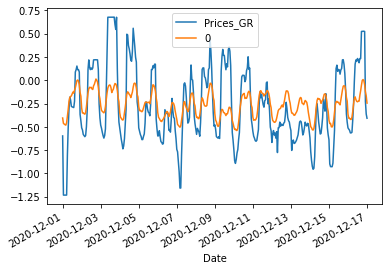

In [20]:
modelLR = LinearRegression()
modelLR.fit(Before_MC_X_train.drop("Just_Date",axis=1),Before_MC_y_train)
print(modelLR.score(Before_MC_X_test.drop("Just_Date",axis=1),Before_MC_y_test))


prediction = modelLR.predict(Before_MC_X_test.drop("Just_Date",axis=1)) #bu modele bu xleri verirsek perdictliycegi yleri veriyo
prediction = pd.Series(prediction, index=Before_MC_y_test.index)
Before_MC_y_test_plot = pd.concat([Before_MC_y_test, prediction], axis=1) #burda testin yanina predicti yapistiriyoruz

pd.concat([Before_MC_y_test_plot,Before_MC[Before_MC["Date"]>="20201201"]["Date"]],axis=1).set_index("Date").plot()

In [32]:
modelDTR = DecisionTreeRegressor()
modelDTR.fit(Before_MC_X_train.drop("Just_Date",axis=1),Before_MC_y_train)
print("Decision Tree Regressor:",modelDTR.score(Before_MC_X_test.drop("Just_Date",axis=1),Before_MC_y_test))

modelRFR = RandomForestRegressor()
modelRFR.fit(Before_MC_X_train.drop("Just_Date",axis=1),Before_MC_y_train)
print("Random Forest Regressor:",modelRFR.score(Before_MC_X_test.drop("Just_Date",axis=1),Before_MC_y_test))

modelLBGM = lgbm.LGBMRegressor()
modelLBGM.fit(Before_MC_X_train.drop("Just_Date",axis=1),Before_MC_y_train)
print("LGBM Regressor:",modelLBGM.score(Before_MC_X_test.drop("Just_Date",axis=1),Before_MC_y_test))

modelGBR = GradientBoostingRegressor()
modelGBR.fit(Before_MC_X_train.drop("Just_Date",axis=1),Before_MC_y_train)
print("Gradient Boosting Regressor:",modelGBR.score(Before_MC_X_test.drop("Just_Date",axis=1),Before_MC_y_test))

modelADA = AdaBoostRegressor()
modelADA.fit(Before_MC_X_train.drop("Just_Date",axis=1),Before_MC_y_train)
print("AdaBoost Regressor:",modelADA.score(Before_MC_X_test.drop("Just_Date",axis=1),Before_MC_y_test))

Decision Tree Regressor: 0.38990074587562684
Random Forest Regressor: 0.5408271362624899
LGBM Regressor: 0.5265240814894072
Gradient Boosting Regressor: 0.47385233231732315
AdaBoost Regressor: 0.2526634739692586


0.3194208970499224


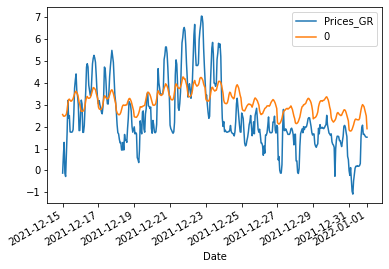

In [21]:
modelLR = LinearRegression()
modelLR.fit(After_MC_X_train.drop("Just_Date",axis=1),After_MC_y_train)
print(modelLR.score(After_MC_X_test.drop("Just_Date",axis=1),After_MC_y_test))


prediction = modelLR.predict(After_MC_X_test.drop("Just_Date",axis=1)) #bu modele bu xleri verirsek perdictliycegi yleri veriyo
prediction = pd.Series(prediction, index=After_MC_y_test.index)
After_MC_y_test_plot = pd.concat([After_MC_y_test, prediction], axis=1) #burda testin yanina predicti yapistiriyoruz

pd.concat([After_MC_y_test_plot,After_MC[After_MC["Date"]>="20211215"]["Date"]],axis=1).set_index("Date").plot()

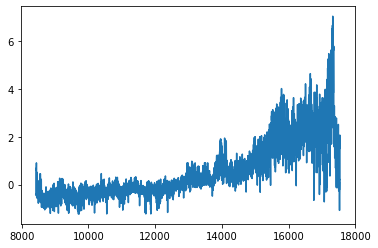

In [22]:
After_MC["Prices_GR"].plot()

In [33]:
modelDTR = DecisionTreeRegressor()
modelDTR.fit(After_MC_X_train.drop("Just_Date",axis=1),After_MC_y_train)
print("Decision Tree Regressor:",modelDTR.score(After_MC_X_test.drop("Just_Date",axis=1),After_MC_y_test))

modelRFR = RandomForestRegressor()
modelRFR.fit(After_MC_X_train.drop("Just_Date",axis=1),After_MC_y_train)
print("Random Forest Regressor:",modelRFR.score(After_MC_X_test.drop("Just_Date",axis=1),After_MC_y_test))

modelLBGM = lgbm.LGBMRegressor()
modelLBGM.fit(After_MC_X_train.drop("Just_Date",axis=1),After_MC_y_train)
print("LGBM Regressor:",modelLBGM.score(After_MC_X_test.drop("Just_Date",axis=1),After_MC_y_test))

modelGBR = GradientBoostingRegressor()
modelGBR.fit(After_MC_X_train.drop("Just_Date",axis=1),After_MC_y_train)
print("Gradient Boosting Regressor:",modelGBR.score(After_MC_X_test.drop("Just_Date",axis=1),After_MC_y_test))

modelADA = AdaBoostRegressor()
modelADA.fit(After_MC_X_train.drop("Just_Date",axis=1),After_MC_y_train)
print("AdaBoost Regressor:",modelADA.score(After_MC_X_test.drop("Just_Date",axis=1),After_MC_y_test))

Decision Tree Regressor: 0.30435659863737285
Random Forest Regressor: 0.41817765567364995
LGBM Regressor: 0.3036662230236348
Gradient Boosting Regressor: 0.3040927275417864
AdaBoost Regressor: 0.25458206848018117
